## Installs

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random
from shapely.geometry import Point, LineString
from gym import Env, spaces
import time
import pydicom as dcm
import cv2 as cv
import os
import torch

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor
from stable_baselines3.common.callbacks import EvalCallback

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.set_device(0)

### Version Specific Features/Improvements


*   Combined the complex and the simple dosing onto one model giving the user the option to use either


### Notes:

* Change the cancer_bool to something a little more concrete

## Classes


### Env

In [12]:
class ParallelBeamEnv(Env):
    def __init__(self):
        super(ParallelBeamEnv, self).__init__()
        self.cancer = CANCER
        self.external = EXTERNAL
        self.match_uid(self.cancer, self.external)
        self.search_space = self.bound_search_space(self.cancer)
        self.learn_space = self.bound_search_space(self.external)
        self.beam = Beam(self.search_space) # Can be reduced by finding the bounds of the relevant contours and only permitting the beam to operate within these regions. NOTE: there will be issues when treating cancers with multiple regions
        self.action_space = spaces.MultiDiscrete([3,3,3,2])# Position of spot, angle of beam, beam intensity
        self.x_min = self.learn_space[0]
        self.x_max = self.learn_space[1]
        self.y_min = self.learn_space[2]
        self.y_max = self.learn_space[3]
        self.x_size = self.x_max - self.x_min
        self.y_size = self.y_max - self.y_min
        self.observation_shape = (self.x_size, self.y_size) # (175, 333, 123, 320), (242, 310, 140, 240), (167, 339, 109, 330)
        self.target_dose = 0.3 # Dose prescription measured in Gy
        self.observation_space = spaces.Dict({
                                "position": spaces.Box(low = np.array(self.search_space[0:3:2]), 
                                                       high = np.array(self.search_space[1:4:2]),
                                                       dtype=int),
                                "cancer bool": spaces.Discrete(2),
                                "dose distribution": spaces.Box(low = -1 * np.ones(self.observation_shape),
                                                                high = np.ones(self.observation_shape),
                                                                dtype=np.float32)})
        self.treatment_period = 1024 # Number of steps per learning perdiod
        self.state = {
            "position": [self.search_space[0], self.search_space[2]],
            "cancer bool": 0,
            "dose distribution":-0.7 * np.array(self.cancer.boolean_map[self.x_min:self.x_max,
                                                                        self.y_min:self.y_max],
                                                                        dtype=np.float32)}
        self.theta_resolution = 45 # How many degrees changed per step
        self.default_dose = 0.1 # Default amount to be used until variable dosing is implemented. Can also be a reference value for decrete choice dosing e.g choices are 0, 0.25, 0.5, 1, 1.5, 2, 2.5x reference dose when choosing
        self.step_size = 3
        self.canvas = -0.7 * np.array(self.cancer.boolean_map, dtype=np.float32)
        self.other_brain_regions = []
        self.reward_multipliers = []
        self.reward_stack = self.calculate_reward_stack()
        self.reward_map = self.reward_stack[0]
        self.update_reward_map()

    def step(self, action):
        """
        Applies the action chosen by the Agent. Calculates 'reward'. Updates the
        'state'. Decreases the treatment period by 1. Updates the 'done' status.
        Returns 'info'. 
        """
        # Initially set reward to zero so if no action taken, reward does not carry over from previous step
        reward = 0
        # Check if plan is done
        if self.treatment_period <= 0: 
            done = True
        else:
            done = False
        
        # Translational Shift
        del_xy = (action[0:2] - 1) * self.step_size # The 1 here can be changed to change step size
        self.beam.move(del_xy[0], del_xy[1])
        self.state["position"] = np.array([self.beam.x, self.beam.y])
        
        if self.is_beam_over_cancer() == True:
            self.state["cancer bool"] = 1
        else:
            self.state["cancer bool"] = 0

        # Angular Shift
        del_theta = (action[2] - 1) * self.theta_resolution
        self.beam.rotate(del_theta)
        # Apply_dose and calculate corresponding reward
        if action[3] == 1:
            reward = self.updated_apply_dose()# Change the dosing methods here
            self.state["dose distribution"] = self.canvas[self.x_min:self.x_max, self.y_min:self.y_max]

        # Check for overdosing
        if (np.max(self.state["dose distribution"]) > self.target_dose):
            reward -= 10
            done = True
        
        # Reduce treatment period by 1; Retaining treatment period approach in case method changes in the future
        self.treatment_period -= 1

        info = {}
        # Rendering for dose checks
        # if done == True:
        #     self.render()
        return self.state, reward, done, info

    def reset(self):
        """
        Resets environment to initial state. Currently set to zeros but could also
        be set to either base CT image. This will also have to change if we move
        from 'Box' to 'Dict' space. 
        """
        # Random Slice
        slice_number = np.random.randint(0, high=len(self.cancer.r_uids)) # 38 being number of slices in the dataset with the CTV cancer involved, 33 in the external
        self.cancer.slice_number = slice_number
        self.match_uid(self.cancer, self.external)
        self.cancer.update_slices()
        self.external.update_slices()
        self.beam.update_search_space(self.cancer.contour_map)
        #(self.beam.x_min, self.beam.x_max, self.beam.y_min, self.beam.y_max) = self.bound_search_space()
        # If other brain region objects added as vector, can iterator through them here

        self.update_reward_map()
        #print(f"Environment has reset using slice number {x}")

        self.treatment_period = 1024
        self.state = {
            "position": np.array([self.search_space[0], self.search_space[2]], dtype=int),
            "cancer bool": 0,
            "dose distribution": -0.7 * np.array(self.cancer.boolean_map[self.x_min:self.x_max,
                                                                         self.y_min:self.y_max],
                                                                         dtype=np.float32)}
        self.beam.x = np.random.randint(self.beam.x_min, self.beam.x_max)
        self.beam.y = np.random.randint(self.beam.y_min, self.beam.y_max)
        # self.beam.x = int((self.beam.x_min + self.beam.x_max) / 2)
        # self.beam.y = int((self.beam.y_min + self.beam.y_max) / 2)
        self.canvas = -0.7 * np.array(self.cancer.boolean_map, dtype=np.float32)
        return self.state
    
    def render(self, mode = "human"):
        """
        Renders the dosing information of the AI upon a CT image.
        """
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            #s_s = self.search_space
            plt.imshow(self.canvas)#[s_s[0]:s_s[2] + 1, s_s[1]:s_s[3]+ 1])
            plt.savefig("LatestDose")# Maybe have the contour outputted for humans as well
            return None
    
        elif mode == "rgb_array":
            return self.canvas

    def is_beam_over_cancer(self):
        """
        Checks if the whole beam is over the cancer contour and if the dose
        exceeds the maximum.
        """
        x = self.beam.x
        y = self.beam.y        
        beam_over_cancer = self.cancer.boolean_map[(y-1):(y+2),(x-1):(x+2)]
        dose = np.max(self.canvas[(y-1):(y+2),(x-1):(x+2)])
        if (np.sum(beam_over_cancer) == 9) and (dose < 0.7):# Just a placeholder for the dose limit
            return True
        else:
            return False

    def apply_dose(self):
        """
        Applies dose (currently just a fixed amount) at given angle and position.
        Currently just going to place 3x3 dose centered on beam position in order
        to implement proof of concept. Then can increase levels of complexity
        from there.
        """
        square_dose = self.default_dose * np.ones((3,3))
        x = self.beam.x
        y = self.beam.y
        dose_overlap = np.sum(self.reward_map[(y-1):(y+2),(x-1):(x+2)] * square_dose)
        normalised_reward = dose_overlap / (9 * self.default_dose)
        self.canvas[(y-1):(y+2),(x-1):(x+2)] += square_dose
        return normalised_reward

    def updated_apply_dose(self):
        """
        Creates a line of a given thickness between two points and applies a 
        custom gradient to said line (function of distance along the line).
        Then calculates a normalised reward based on the overlap of dose and
        contour.
        """
        x = self.beam.x
        y = self.beam.y
        theta = self.beam.theta
        # Defining properties of each circle to be drawn
        radius = 2
        n=0
        score = 0
        if not self.within_patient(x,y):# Just double check this later
        #     print("Not within patient")
            score -= 0.1
        # else:
        #     print("Within target")

        if theta == 0:
            while(self.within_patient(x+n,y)):
                value = self.beam.calculate_dose_gradient(n)
                self.canvas[y+n,x-radius:x+radius+1] += value
                score += np.sum(self.reward_map[y+n,x-radius:x+radius+1]) * value / (2*radius + 1)
                n += 1

        elif theta == 180:
            while(self.within_patient(x-n,y)):
                value = self.beam.calculate_dose_gradient(n)
                self.canvas[y-n,x-radius:x+radius+1] += value
                score += np.sum(self.reward_map[y-n,x-radius:x+radius+1]) * value / (2*radius + 1)
                n += 1

        elif theta == 90:
            while(self.within_patient(x,y+n)):
                value = self.beam.calculate_dose_gradient(n)
                self.canvas[y-radius:y+radius+1,x+n] += value
                score += np.sum(self.reward_map[y-radius:y+radius+1,y+n]) * value / (2*radius + 1) # Multiplicative term at the end here is a normalisation factor (value [0,1], 2x Radius + 1 pixels per step)
                n += 1

        elif theta == 270:
            while(self.within_patient(x,y-n)):
                value = self.beam.calculate_dose_gradient(n)
                self.canvas[y-radius:y+radius+1,y-n] += value
                score += np.sum(self.reward_map[y-radius:y+radius+1,x-n]) * value / (2*radius + 1)
                n += 1

        elif theta < 90 or theta > 270:
            m = np.rint(np.tan(theta*np.pi/180))
            while(self.within_patient(x+n,int(y+m*n))):
                distance = n * np.sqrt(1 + m**2) # should always be sqrt(2) x n for this model but writing like this in case theta precision changes
                value = self.beam.calculate_dose_gradient(distance)
                for r in range(2*radius+1):
                    k = r - radius
                    self.canvas[y+n-k, int(x+m*(n+k))] += value
                    score += np.sum(self.reward_map[y+n-k, int(x+m*(n+k))]) * value / (2*radius + 1)  
                for r in range(2*radius):
                    k = r - radius
                    self.canvas[y+n+k, int(x+m*(n-k-1))] += value
                    score += np.sum(self.reward_map[y+n+k, int(x+m*(n-k-1))]) * value / (2*radius)
                n += 1

        elif theta > 90 and theta < 270:
            m = np.rint(np.tan(theta*np.pi/180))
            while(self.within_patient(x-n,int(y-m*n))):
                distance = n * np.sqrt(1 + m**2) # should always be sqrt(2) x n for this model but writing like this in case theta precision changes
                value = self.beam.calculate_dose_gradient(distance)
                for r in range(2*radius+1):
                    k = r - radius
                    self.canvas[y-n-k,int(x-m*(n-k))] += value
                    score += np.sum(self.reward_map[y-radius:y+radius+1,x-n]) * value / (2*radius + 1)

                for r in range(2*radius):
                    k = r - radius
                    self.canvas[y-n+k, int(x-m*(n+k+1))] += value
                    score += np.sum(self.reward_map[y-n+k, int(x-m*(n+k+1))]) * value / (2*radius)
                n += 1
        return score

    def bound_search_space(self, region):
        """
        Runs through each element in binary map for each slice in a region and
        outputs the maximum and minimum boundaries for each contour region.
        """
        min_x = 512
        max_x = 0
        min_y = 512
        max_y = 0
        for k in range(len(region.binary_stack)):
            for i in range(512):
                for j in range(512):
                    if region.binary_stack[k][j,i] == 1:
                        if i < min_x:
                            min_x = i
                        if i > max_x:
                            max_x = i
                        if j < min_y:
                            min_y = j
                        if j > max_y:
                            max_y = j

        return (int(min_x), int(max_x), int(min_y), int(max_y))

    def within_cancer(self, i, j):
        """
        Returns a True if the coordinates are within the contour, else returns
        False.
        """
        
        if max(i,j) > 512 or min(i,j) < 0:
            return False
        elif self.cancer.contour_map[j,i] == 1:
            return True
        else:
            return False

    def within_patient(self, i, j):
        """
        Returns a True if the coordinates are within the contour, else returns
        False.
        """
        if max(i,j) > 512 or min(i,j) < 0:
            return False
        elif self.external.contour_map[j,i] == 1:
            return True
        else:
            return False
    
    # def add_to_reward_map(self, brain_region, multiplier):
    #     """
    #     Adds a brain region object to the reward map with its associated
    #     multiplier displayed.
    #     """
    #     self.other_brain_regions.append(brain_region)
    #     self.multipliers.append(multiplier)
    #     self.reward_map = self.calculate_reward_map()
    
    def calculate_reward_stack(self):
        """
        Calculates a 3D 
        """
        reward_arrays = []
        
        for i in range(len(self.cancer.boolean_stack)):
            self.cancer.slice_number = i
            self.match_uid(self.cancer, self.external)
            self.cancer.update_slices()
            self.external.update_slices()
            ith_reward_map = self.calculate_reward_map()
            reward_arrays.append(ith_reward_map)
        reward_stack = np.stack(reward_arrays)
        return reward_stack

    def calculate_reward_map(self):
        """
        Calculates a reward map that priritises the cancer contour. Other 
        contours can be added via the add_to_reward_map() function.
        """
        reward_map = np.zeros((512,512))
        # Calculates lowest hierachy first
        reward_map[self.external.boolean_stack[self.external.slice_number]] = -1
        
        # for i in range(len(other_brain_regions)):
        #     reward_map[other_brain_regions[i].boolean_map] = multipliers[i]

        # Calculates highest hierachy last
        reward_map[self.cancer.boolean_stack[self.cancer.slice_number]] = 1

        return reward_map
    
    def update_reward_map(self):
        """
        Updates the reward map to the givn slice index.
        """
        self.reward_map = self.reward_stack[self.cancer.slice_number]

    def match_uid(self, region_1, region_2):
        """
        Takes region and a slice index of that region and finds the 
        corresponding slice in a second given region using referenced UID
        matching. If a match is found it updates the second region's slice 
        number.
        """
        slice_id = region_1.r_uids[region_1.slice_number]
        for i in range(len(region_2.r_uids)):
            if region_2.r_uids[i] == slice_id:
                region_2.slice_number = i
                return None
                
        raise Exception(f"Slice {region_1.slice_number} from {region_1.contour_name} could not be matched with {region_2.contour_name}.")



### Beam

In [13]:
class Beam(object):
    def __init__(self, contour_region):
        (self.x_min, self.x_max, self.y_min, self.y_max) = contour_region
        self.x = self.x_min
        self.y = self.y_min
        self.theta = 0
        self.distance_from_cancer = 0
        self.distance_from_cord = 0

    def get_position(self):
        return (self.x, self.y)

    def move(self, del_x, del_y):
        """
        Moves the x,y values by some prescribed amount. The position is then 
        bounded by the values set by the observation space.
        """
        self.x += del_x
        self.y += del_y

        self.x = self.bound(self.x, self.x_min, self.x_max)
        self.y = self.bound(self.y, self.y_min, self.y_max)

    def rotate(self, del_theta):
        """
        Increases the value of theta in the anti-clockwise direction. Measured 
        in degrees, modular(360). 
        """
        self.theta = (self.theta + del_theta)%360

    def bound(self, n, minn, maxn):
        """
        Bounds a given number, n, between some given minimum and maximum, 
        (minn, maxn). If n exceeds the boundary, returns the closest allowed
        value.
        """
        return max(min(maxn,n), minn)

    def update_search_space(self, contour_map):
        """
        Runs through each element in binary map
        """
        min_x = 512
        max_x = 0
        min_y = 512
        max_y = 0
        for i in range(512):
            for j in range(512):
                if contour_map[j,i] == 1:
                    if i < min_x:
                        min_x = i
                    if i > max_x:
                        max_x = i
                    if j < min_y:
                        min_y = j
                    if j > max_y:
                        max_y = j

        (self.x_min, self.x_max, self.y_min, self.y_max) = (min_x, max_x, min_y, max_y)

    def find_proton_energy():
        """
        Finds the proton energy required to place the Bragg peak of the spot at
        the required location in the brain given the location of the beam
        """
    def calculate_dose_gradient(self, distance):
        """
        A WET approximation calculation to give the intensity of dose as a
        function of distance from beam spot
        """
        return 0.1 * np.exp(-(distance**2)/3)


### Brain Region

In [14]:
class BrainRegion(object):
    def __init__(self, contour_name, threshold):
        self.contour_name = contour_name
        self.threshold = threshold
        self.structure = STRUCTURE
        self.roi_num = self.get_roi_index(contour_name)
        self.slice_number = 0 # Will be removed when moving to multiple layers of CT
        self.contour_coords = self.map_contour_to_ct(self.roi_num)
        self.boolean_map, self.contour_map = self.create_contour_map(self.contour_coords)
        self.coordinate_stack, self.r_uids = self.get_coordinate_stack()
        self.boolean_stack, self.binary_stack = self.get_contour_stack()

    def get_roi_index(self, roi_name):
        """
        Takes a string and outputs the roi location within the structure file of
        corresponding contour e.g CTV 70, brainstem etc.
        """
        roi_num = 0
        while roi_name != self.structure.StructureSetROISequence[roi_num].ROIName:
            roi_num += 1
            if roi_num > len(self.structure.StructureSetROISequence) - 1:
                raise Exception("Sorry, that name is not contained in this Structure Sequence")
        print(f"The ROI index for {roi_name} is {roi_num}")
        return roi_num

    def get_coordinate_stack(self):
        """
        Returns the set of contours present in a 2D CT scan.
        """
        roi_contours = []
        referenced_uids = []
        for slice in os.scandir(DIRECTORY):
            if slice.is_file():
                ds_ct = dcm.dcmread(slice.path)
                slice_id = ds_ct.SOPInstanceUID
                # Plotting iteratively through all the contours of one ROI on one CT scan
                for j in range(len(self.structure.ROIContourSequence[self.roi_num].ContourSequence)):
                    for k in range(len(self.structure.ROIContourSequence[self.roi_num].ContourSequence[j].ContourImageSequence)):
                        if self.structure.ROIContourSequence[self.roi_num].ContourSequence[j].ContourImageSequence[k].ReferencedSOPInstanceUID == slice_id:
                            point_number = self.structure.ROIContourSequence[self.roi_num].ContourSequence[j].NumberOfContourPoints

                            contour_array_old_coords = np.reshape(self.structure.ROIContourSequence[self.roi_num].ContourSequence[j].ContourData, (point_number, 3))
                            new_x = (contour_array_old_coords[:,0] - ds_ct.ImagePositionPatient[0])/ ds_ct.PixelSpacing[0]
                            new_y = (contour_array_old_coords[:,1] - ds_ct.ImagePositionPatient[1])/ ds_ct.PixelSpacing[1]
                            #ct_z_coord = contour_array_old_coords[:,2]
                            contour_data = np.array([new_x, new_y])
                            roi_contours.append(contour_data)
                            referenced_uids.append(slice_id)
                            continue

        return roi_contours, referenced_uids

    def get_contour_stack(self):
        """
        Returns a 3D stack of contours in binary and boolean data types.
        """
        binary_arrays = []
        boolean_arrays = []
        for i in range(len(self.coordinate_stack)):
            ith_boolean, ith_binary = self.create_contour_map(self.coordinate_stack[i])
            binary_arrays.append(ith_binary)
            boolean_arrays.append(ith_boolean)

        binary_stack = np.stack(binary_arrays)
        boolean_stack = np.stack(boolean_arrays)
        return boolean_stack, binary_stack

    def map_contour_to_ct(self, roi_num):
        """
        Maps the list of contour values to (3,n) dimensional array of x,y,z
        coords that match CT space.
        """
        point_number = self.structure.ROIContourSequence[roi_num].ContourSequence[self.slice_number].NumberOfContourPoints
        contour_array_old_coords = np.reshape(np.array(self.structure.ROIContourSequence[roi_num].ContourSequence[self.slice_number].ContourData), (point_number, 3))
        patient_pos_x = np.full(np.shape(contour_array_old_coords[:,0]), float(CT_FILE.ImagePositionPatient[0]))
        patient_pos_y = np.full(np.shape(contour_array_old_coords[:,1]), float(CT_FILE.ImagePositionPatient[1]))
        new_x = (contour_array_old_coords[:,0] - patient_pos_x) / float(CT_FILE.PixelSpacing[0])
        new_y = (contour_array_old_coords[:,1] - patient_pos_y) / float(CT_FILE.PixelSpacing[1])
        ct_z_coord = contour_array_old_coords[:,2]
        contour_data = np.array([new_x, new_y]) #np.array([new_x, new_y, ct_z_coord])

        return contour_data

    def create_contour_map(self, contour):
        """
        Takes a list of x,y coordinates and creates a map of size (512,512)
        containing the contour. The map has values of -1 outside the contour, 0 
        on the contour and +1 inside the contour.
        """

        x_vals = contour[0,:]
        y_vals =  contour[1,:]
        contour_xy = list(map(lambda x, y:(int(np.rint(x)),int(np.rint(y))), x_vals, y_vals))

        src = np.zeros((512, 512), dtype=np.uint8)
        num_points = len(x_vals)

        for i in range(num_points):
            cv.line(src, contour_xy[i], contour_xy[(i+1)%num_points], ( 255 ), 3)
        # Get the contours
        contours, hierarchy = cv.findContours(src, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        
        boolean_map = np.empty(src.shape, dtype=bool)
        binary_map = np.empty(src.shape)
        
        for i in range(src.shape[0]):
            for j in range(src.shape[1]):
                if cv.pointPolygonTest(contours[0], (j,i), False)>0:
                    binary_map[i,j] = 1
                    boolean_map[i,j] = True
                else:
                    binary_map[i,j] = -1
                    boolean_map[i,j] = False
        
        return boolean_map, binary_map

    def update_slices(self):
        """
        Updates the active slice in the brain regions (to the one chosen in the 
        reset method). 
        """
        self.boolean_map = self.boolean_stack[self.slice_number]
        self.contour_map = self.binary_stack[self.slice_number]

## Global Variables and Objects

In [15]:
DOSE_PATH = "/workspaces/MPhys Gamification/HNSCC-01-0001_DICOM/RD.HNSCC-01-0001.4MPhys.dcm"
STRUCTURE_PATH = "/workspaces/MPhys Gamification/HNSCC-01-0001_DICOM/RS.HNSCC-01-0001.Oropharynx.dcm"
CT_PATH = "/workspaces/MPhys Gamification/HNSCC-01-0001_DICOM/CT.HNSCC-01-0001.Image 22.dcm"
DIRECTORY = "/workspaces/MPhys Gamification/HNSCC-01-0001_DICOM"
CT_FILE = dcm.dcmread(CT_PATH)
STRUCTURE = dcm.dcmread(STRUCTURE_PATH)
DOSE_FILE = dcm.dcmread(DOSE_PATH)

In [16]:
# Global BrainRegion objects
CANCER = BrainRegion("CTV 70 Sub", 0.7)
EXTERNAL = BrainRegion("External", 1)

The ROI index for CTV 70 Sub is 11
The ROI index for External is 23


## Checking Env

/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/env_checker.py:130: UserWarning: Your observation dose distribution has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


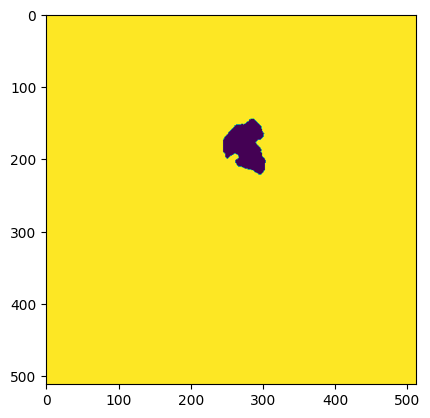

In [17]:
env = ParallelBeamEnv()
# It will check your custom environment and output additional warnings if needed
check_env(env)
env.render()

###Running with Multiprocessing

In [18]:
print(os.getcwd())
logdir = "./logdir"
modeldir = "./modeldir"

if not os.path.exists(modeldir):
    os.makedirs(modeldir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

/workspaces/MPhys Gamification


In [19]:
num_processers = 16 # Number of processes to use
env = make_vec_env(ParallelBeamEnv, n_envs=num_processers, vec_env_cls=SubprocVecEnv)
model = PPO('MultiInputPolicy', env, verbose=1, device="cuda", n_steps=2048, tensorboard_log=logdir)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.wa

Using cuda device


/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [20]:
model.save("LearningBout0")
n_timesteps = 5000000
number_of_saves = 10
total_time_multi = 0
# Multiprocessed RL Training
for i in range(number_of_saves):
    model.load(f"LearningBout{i}")
    start_time = time.time()
    model.learn(n_timesteps / number_of_saves, tb_log_name="Final2D_v1.2")
    total_time_multi += time.time() - start_time
    model.save(f"LearningBout{i+1}")

print(f"Took {total_time_multi:.2f}s for multiprocessed version - {n_timesteps / total_time_multi:.2f} FPS")

Logging to ./logdir/Final2D_v1.2_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 87.1     |
|    ep_rew_mean     | -6.43    |
| time/              |          |
|    fps             | 979      |
|    iterations      | 1        |
|    time_elapsed    | 33       |
|    total_timesteps | 32768    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 114         |
|    ep_rew_mean          | -4.09       |
| time/                   |             |
|    fps                  | 590         |
|    iterations           | 2           |
|    time_elapsed         | 111         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.006817124 |
|    clip_fraction        | 0.0756      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.98       |
|    explained_variance   | -0.00603 

## Testing

/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


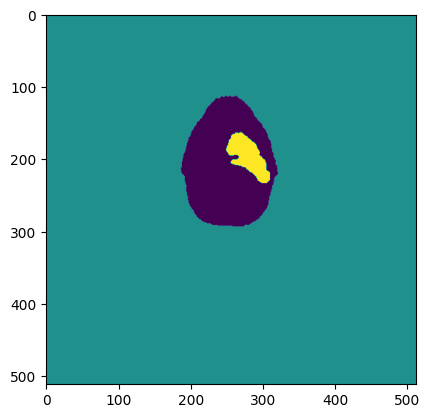

In [ ]:
test_env = ParallelBeamEnv()
plt.imshow(test_env.reward_stack[8])

In [ ]:
plt.imshow(test_env.external.boolean_stack[8])

In [ ]:
def test():
    slice_id = CANCER.r_uids[CANCER.slice_number]
    for i in range(len(EXTERNAL.r_uids)):
        if EXTERNAL.r_uids[i] == slice_id:
            EXTERNAL.slice_number = i
            return None
            
    raise Exception(f"Slice {CANCER.slice_number} from {CANCER.contour_name} could not be matched with {EXTERNAL.contour_name}.")

for j in range(29):
    #x =  #np.random.randint(0, high=len(CANCER.r_uids)) # 38 being number of slices in the dataset with the CTV cancer involved, 33 in the external
    CANCER.slice_number = j
    test()



In [ ]:
def test2(region):
    """
    Runs through each element in binary map
    """
    min_x = 512
    max_x = 0
    min_y = 512
    max_y = 0
    for k in range(len(region.coordinate_stack)):
        for i in range(512):
            for j in range(512):
                if region.binary_stack[k][j,i] == 1:
                    if i < min_x:
                        min_x = i
                    if i > max_x:
                        max_x = i
                    if j < min_y:
                        min_y = j
                    if j > max_y:
                        max_y = j

    return (min_x, max_x, min_y, max_y)

print(test2(EXTERNAL))

In [ ]:
for i in range(len(CANCER.r_uids) + 1):
    if CANCER.r_uids[i] == EXTERNAL.r_uids[i+2]:
        print(f"Index {i}")


In [ ]:
len(STRUCTURE.ROIContourSequence[32].ContourSequence)
STRUCTURE.ROIStructureSetSequence[32].ROIName

In [ ]:
model.get_env().render()

In [ ]:
plt.imshow(model.get_env().cancer.contour_map)